# PyTorch Paper Replicating

This file will focus on replicating a Machine Learning research paper and creating a Vision Transformer (ViT) from scratch.

### What is paper replicating?

The goal of paper replicating is to replicate the most recent advances in Machine Learning which tend to be published in papers. Instead of using someone else's code, the focus here is to transform images, diagrams, math and text into usable code, in this case, PyTorch code.

### Where can code examples of Machine Learning research papers be found?

There is a lot of research in Machine Learning, so staying on top of the most recent advances is not easy. Said this, there are several places to find relevant papers.

Some useful resources include:
* arXiv
* AK Twitter
* Papers with Code
* lucidrains' `vit-pytorch` GitHub repository

### Which paper will be replicated?

The paper this file will focus on An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (ViT paper)
https://arxiv.org/abs/2010.11929

The Transformer neural network architecture was originally introduced in the Machine Learning research paper Attention is all you need
https://arxiv.org/abs/1706.03762

A Transformer architecture is generally considered to be any neural network that uses the attention mechanism as its primary learning layer. This is similar to how Convolutional Neural Networks use convolutions as their primary learning layer.

The Attention Mechanism is more thoroughly explained here:
https://www.geeksforgeeks.org/ml-attention-mechanism/

As suggested by its name, the Vision Transformer (ViT) architecture was designed to adapt the original Transformer architecture to vision problems.

The original Vision Transformer has been through several iterations over the past couple of years, but we will focus on replicating the original.

For the rest of this project, we will refer to the Vision Transformer as ViT while referring to the original Machine Learning research paper as ViT paper.

## 0. Setup

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[0]) >= 2, "torch version should be 2.+"
    assert int(torchvision.__version__.split(".")[1]) >= 15, "torchvision version should be 0.15+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not correct. Installing correct versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Could not find going_modular scripts. Downloading them from GitHub.")
    !git clone https://github.com/Aaron-Serpilin/Zero-To-Mastery-Pytorch
    !mv Zero-To-Mastery-Pytorch/Fundamentals/going_modular .
    !mv Zero-To-Mastery-Pytorch/Fundamentals/helper_functions.py .
    !rm -rf Zero-To-Mastery-Pytorch
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Could not find going_modular scripts. Downloading them from GitHub.
Cloning into 'Zero-To-Mastery-Pytorch'...
remote: Enumerating objects: 627, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 627 (delta 3), reused 0 (delta 0), pack-reused 617 (from 1)
Receiving objects: 100% (627/627), 112.02 MiB | 21.95 MiB/s, done.
Resolving deltas: 100% (117/117), done.
Updating files: 100% (352/352), done.
mv: cannot move 'Zero-To-Mastery-Pytorch/Fundamentals/going_modular' to './going_modular': Directory not empty


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data

In [6]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

### 2.1 Prepare transforms for images

In [8]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Turn images into `DataLoader`'s

The ViT paper states the use of a batch size of 4096, which is considerably bigger than the batch size of 32 we have been using so far. However, we will stick with 32 because due to hardware limitations, handling batches of 4096 would be challenging.

In [9]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f35754eaed0>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [10]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

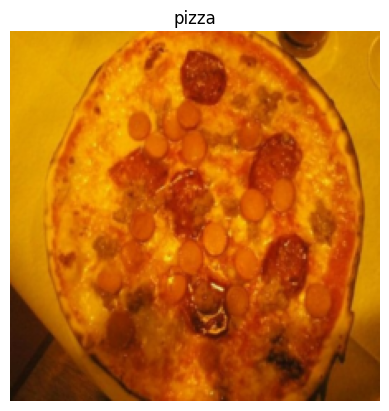

In [11]:
plt.imshow(image.permute(1, 2, 0)) # rearrange to suit matplotlib (go from [CHW] to [HWC])
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating the ViT paper: an overview

### 3.1 Inputs and Outputs, Layer and Blocks

Neural networks are composed of layers, which can be grouped together into blocks. Said blocks can then be stacked together to provide a more thorough architecture.

Here is a breakdown of these:

* Layer: takes an input, performs a function on it, returns an output.
* Block: a collection of layers, takes an input, performs a series of functions on it, returns an output.
* Architecture (or model): a collection of blocks, takes an input, performs a series of functions on it, returns an output.

When replicating a paper, one must do it layer by layer, block by block, function by function.

### 3.2 What is ViT made of?

The ViT model paper has many details, but our focus of analysis are three resources:

1. Figure 1: gives an overview of the model in a graphical sense. You could almost recreate the architecture with this figure alone.
2. Four equations in section 3.1: These equations give a little bit more of a mathematical grounding to the colored blocks in Figure 1.
3. Table 1: This table shows the various hyperparameter settings for different ViT model variants.

#### 3.1.2 Figure 1

The main analysis of this section is around two features:

1. Layers
2. Blocks

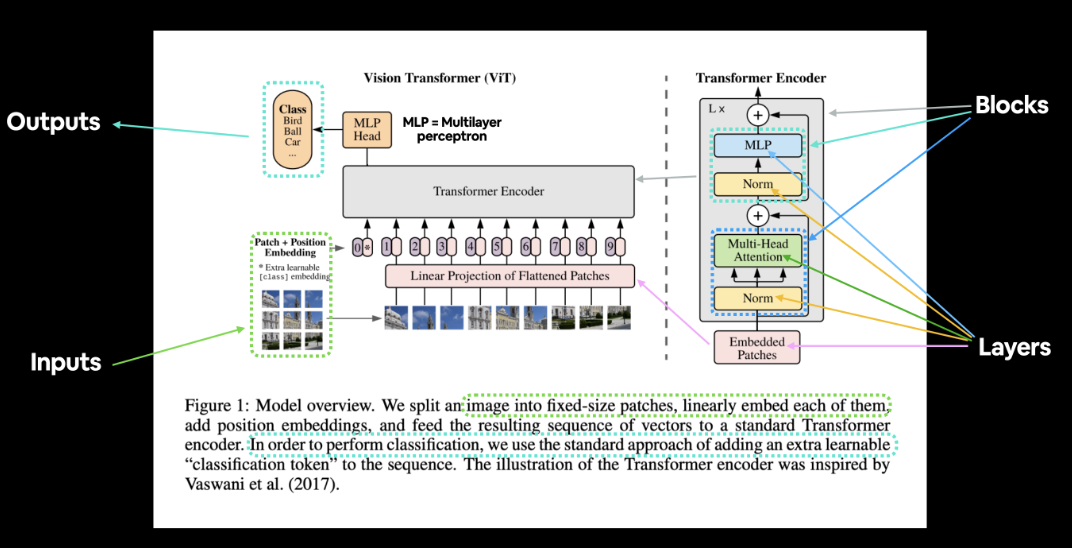

The ViT Architecture is comprised of several stages:

* **Patch + Position Embedding (inputs)**: Converts the input image into a sequence of image patches. A position number is then added given that transformers are almost a type of content based set operation. Hence, in order for it to retain positional information, it is assigned a position number and is passed to the self attention.
* **Linear Projection of Flattened Patches (Embedded Patches)**: The image patches get turned into an embedding which are essentially learnable representations. This extracts more data and meanings from the image patches, and can improve with training.
* **Norm**: Short for Layer Normalization or LayerNorm. It is a technique for regularizing (reducing overfitting) in a neural network. It can be used through `torch.nn.LayerNorm()`
* **Multi-Head Attention**: The model employs a MSA layer which allows it to focus on multiple parts of the input sequences simultaneously. This can be used through `torch.nn.MultiheadAttention()`
* **Multilayer Perceptron (MLP)**: A MLP can often refer to any collection of feedforward layers, which in PyTorch are a collection of layers with a `forward()` method. In the ViT paper, the authors refer to this as a 'MLP Block', which contains two `torch.nn.Linear()` layers with a `torch.nn.GELU()` non-linearity activation in between. This is detailed in section 3.1, which is complemented by a `torch.nn.Dropout()` layer after each, detailed in Appendix B.1.
* **Transformer Encoder**: The Transformer Encoder is a collection of the layers listed above. These are complemented by two skip (or residual) connections inside the Transformer's encoder. This means that the inputs are fed directly to immediate layers as well as subsequent layers. This is benefitial because it allows that at the start of the training, when the gradient signal is still being initialized, the second signal goes through without any delay due to initialization. Hence, the lower layers can start training on this signal, and then incorporate the gradient once it is propagated through the block. Overall, it facilitates gradient flow, helps the model learn modifications rather than complete transformations, and stabilizes training.
* **MLP Head**: This is the output layer, it converts the learned features of an input to a class output. This could be seen as the classifier head.

Given the detail of the paper, everything could be coded from scratch, which would be a challenging and educative exercise. However, pre-existing PyTorch layers have already been extensively tested and performance checked.

#### 3.2.2 The Four Equations